In [7]:
import sys
sys.executable

'c:\\Users\\USUARIO\\Desktop\\ECO_HENO\\.venv\\Scripts\\python.exe'

In [8]:
import sys
!"{sys.executable}" -m pip install setuptools


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
%matplotlib inline

In [10]:
# Cargar las librería de requirements.txt

import streamlit as st
import pandas as pd
import numpy as np
import joblib
import plotly.express as px   # si tienes gráficos interactivos


In [11]:
# CARGAR BASE DE DATOS BASE ECO HENO
df = pd.read_excel('../data/BASE_ECO_HENO_F.xlsx')

# FASE 1

## 1.1 Unificar el Excel en formato “largo”

In [12]:
# 1) Unificar los 4 bloques en formato largo
base_cols = ["AÑO", "MES", "DÍAS", "FECHA COMPLETA"]
suffixes = ["", ".1", ".2", ".3"]

bloques = []
for suf in suffixes:
    act   = f"ACTIVIDAD DEL DÍA SECTOR{suf}"
    sec   = f"SECTOR{suf}"
    notas = f"NOTAS{suf}"
    prod  = f"PRODUCCION DE HENO SECTOR{suf}"

    # Validación de que existan las columnas esenciales del bloque
    if sec in df.columns and act in df.columns:
        cols = base_cols + [act, sec]

        tmp = df[cols].copy()

        # NOTAS (si no existe, se crea vacía)
        tmp["NOTAS"] = df[notas] if notas in df.columns else np.nan

        # PRODUCCIÓN (si no existe, se crea vacía)
        tmp["PRODUCCION_HENO"] = df[prod] if prod in df.columns else np.nan

        # Renombrar a nombres estándar
        tmp = tmp.rename(columns={act: "ACTIVIDAD", sec: "SECTOR"})

        bloques.append(tmp)

df_unificada = pd.concat(bloques, ignore_index=True)

# 2) Limpieza mínima y tipos
df_unificada["FECHA COMPLETA"] = pd.to_datetime(df_unificada["FECHA COMPLETA"], errors="coerce")
df_unificada["SECTOR"] = pd.to_numeric(df_unificada["SECTOR"], errors="coerce")
df_unificada["PRODUCCION_HENO"] = pd.to_numeric(df_unificada["PRODUCCION_HENO"], errors="coerce")

# eliminar filas sin sector o sin fecha (opcional, pero recomendado para proceso)
df_unificada = df_unificada.dropna(subset=["SECTOR", "FECHA COMPLETA"]).copy()
df_unificada["SECTOR"] = df_unificada["SECTOR"].astype(int)

# 3) Checkpoint solicitado
print("df_unificada.shape:", df_unificada.shape)
print("Columnas disponibles:", list(df_unificada.columns))

faltantes = [c for c in ["SECTOR", "FECHA COMPLETA", "ACTIVIDAD", "PRODUCCION_HENO", "NOTAS"] if c not in df_unificada.columns]
print("Columnas mínimas faltantes:", faltantes)

print("\nMuestra de datos:")
print(df_unificada[["SECTOR", "FECHA COMPLETA", "ACTIVIDAD", "PRODUCCION_HENO", "NOTAS"]].head(10))

df_unificada.shape: (334, 8)
Columnas disponibles: ['AÑO', 'MES', 'DÍAS', 'FECHA COMPLETA', 'ACTIVIDAD', 'SECTOR', 'NOTAS', 'PRODUCCION_HENO']
Columnas mínimas faltantes: []

Muestra de datos:
   SECTOR FECHA COMPLETA        ACTIVIDAD  PRODUCCION_HENO  \
0       1     2022-01-03            CORTE      7525.480000   
1       1     2022-01-04   SECADO – Día 1      6324.640000   
2       1     2022-01-05   SECADO – Día 2      5788.900000   
3       1     2022-01-06   VOLTEO – Día 1      5424.520000   
4       1     2022-01-07   VOLTEO – Día 2      5193.500000   
5       1     2022-01-08  Empaque – Día 1       831.411667   
6       1     2022-01-11  Empaque – Día 2       775.599235   
7       1     2022-01-12  Empaque – Día 3       831.411667   
8       1     2022-01-13  Empaque – Día 4       831.411667   
9       1     2022-01-14  Empaque – Día 5       831.411667   

                   NOTAS  
0         BIOMASA FRESCA  
1      REDUCCION SECADOS  
2      REDUCCION SECADOS  
3      REDUCCION

## 1.2 Normalizar ACTIVIDAD y crear ACTIVIDAD_NORM

In [13]:
df_unificada["ACTIVIDAD_NORM"] = (
    df_unificada["ACTIVIDAD"]
    .astype(str)              # protege contra NaN
    .str.upper()              # todo en mayúsculas
    .str.replace("–", "-", regex=False)
    .str.replace("—", "-", regex=False)
    .str.replace("Á", "A", regex=False)
    .str.replace("É", "E", regex=False)
    .str.replace("Í", "I", regex=False)
    .str.replace("Ó", "O", regex=False)
    .str.replace("Ú", "U", regex=False)
    .str.strip()
)

In [14]:
# Ver primeras filas normalizadas
df_unificada["ACTIVIDAD_NORM"].head(10)


0              CORTE
1     SECADO - DIA 1
2     SECADO - DIA 2
3     VOLTEO - DIA 1
4     VOLTEO - DIA 2
5    EMPAQUE - DIA 1
6    EMPAQUE - DIA 2
7    EMPAQUE - DIA 3
8    EMPAQUE - DIA 4
9    EMPAQUE - DIA 5
Name: ACTIVIDAD_NORM, dtype: object

In [15]:
# Verificar que no sea todo NaN
df_unificada["ACTIVIDAD_NORM"].isna().sum(), df_unificada.shape[0]


(np.int64(0), 334)

## 1.3 — Crear la variable ETAPA

In [16]:
df_unificada["ETAPA"] = np.select(
    [
        df_unificada["ACTIVIDAD_NORM"].str.contains("CORTE", na=False),
        df_unificada["ACTIVIDAD_NORM"].str.contains("SECAD", na=False),
        df_unificada["ACTIVIDAD_NORM"].str.contains("VOLT",  na=False),
        df_unificada["ACTIVIDAD_NORM"].str.contains("EMPAQ", na=False),
    ],
    ["CORTE", "SECADO", "VOLTEO", "EMPAQUE"],
    default="OTRA/NO CLASIFICADA"
)

In [17]:
df_unificada["ETAPA"].value_counts(dropna=False)


ETAPA
EMPAQUE                167
SECADO                  63
VOLTEO                  59
CORTE                   32
OTRA/NO CLASIFICADA     13
Name: count, dtype: int64

In [18]:
df_unificada[["ACTIVIDAD_NORM", "ETAPA"]].head(15)


,ACTIVIDAD_NORM,ETAPA
0,CORTE,CORTE
1,SECADO - DIA 1,SECADO
2,SECADO - DIA 2,SECADO
3,VOLTEO - DIA 1,VOLTEO
4,VOLTEO - DIA 2,VOLTEO
5,EMPAQUE - DIA 1,EMPAQUE
6,EMPAQUE - DIA 2,EMPAQUE
7,EMPAQUE - DIA 3,EMPAQUE
8,EMPAQUE - DIA 4,EMPAQUE
9,EMPAQUE - DIA 5,EMPAQUE


## 1.4 — Extraer DIA_EMPAQUE

In [19]:
df_unificada["DIA_EMPAQUE"] = (
    df_unificada["ACTIVIDAD_NORM"]
    .str.extract(r"DIA\s*(\d+)", expand=False)
    .astype(float)
)

In [20]:
# Verificar valores extraídos
df_unificada[df_unificada["ETAPA"] == "EMPAQUE"][["ACTIVIDAD_NORM", "DIA_EMPAQUE"]].head(15)


,ACTIVIDAD_NORM,DIA_EMPAQUE
5,EMPAQUE - DIA 1,1.0
6,EMPAQUE - DIA 2,2.0
7,EMPAQUE - DIA 3,3.0
8,EMPAQUE - DIA 4,4.0
9,EMPAQUE - DIA 5,5.0
10,EMPAQUE - DIA 6,6.0
220,EMPAQUE - DIA 1,1.0
221,EMPAQUE - DIA 2,2.0
222,EMPAQUE - DIA 3,3.0
223,EMPAQUE - DIA 4,4.0


In [21]:
# Distribución de días de empaque
df_unificada[df_unificada["ETAPA"] == "EMPAQUE"]["DIA_EMPAQUE"].value_counts().sort_index()


DIA_EMPAQUE
1.0    28
2.0    28
3.0    28
4.0    28
5.0    28
6.0    27
Name: count, dtype: int64

# FASE 2 — Entender el proceso (EDA del sistema)

## 2.1 — Verificación temporal básica

In [22]:
df_unificada["FECHA COMPLETA"].min(), df_unificada["FECHA COMPLETA"].max()


(Timestamp('2022-01-03 00:00:00'), Timestamp('2025-01-30 00:00:00'))

## 2.2 — Conteo por sector y etapa

In [23]:
df_unificada.groupby(["SECTOR", "ETAPA"]).size().unstack(fill_value=0)


ETAPA,CORTE,EMPAQUE,OTRA/NO CLASIFICADA,SECADO,VOLTEO
SECTOR,,,,,
1,8,42,2,16,16
2,8,42,3,16,15
3,8,42,3,16,14
4,8,41,4,15,14
5,0,0,1,0,0


## 2.3 — Producción por etapa (visión general)

In [24]:
df_unificada.groupby("ETAPA")["PRODUCCION_HENO"].describe()


,count,mean,std,min,25%,50%,75%,max
ETAPA,,,,,,,,
CORTE,32.0,7344.788750,898.376524,6034.000000,6438.805000,7373.340000,8067.825000,8923.450000
EMPAQUE,167.0,717.693880,148.776629,188.009256,630.683333,743.208333,826.265667,946.443333
OTRA/NO CLASIFICADA,11.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SECADO,63.0,5494.965238,1311.050028,0.000000,4929.385000,5748.600000,6249.745000,7505.820000
VOLTEO,59.0,4755.682034,1127.194995,0.000000,4187.155000,5027.930000,5449.070000,6115.310000


## 2.4 — Confirmar decisión metodológica

In [25]:
df_unificada[df_unificada["ETAPA"] == "EMPAQUE"][
    ["SECTOR", "FECHA COMPLETA", "DIA_EMPAQUE", "PRODUCCION_HENO"]
].sort_values(["SECTOR", "FECHA COMPLETA", "DIA_EMPAQUE"]).head(20)


,SECTOR,FECHA COMPLETA,DIA_EMPAQUE,PRODUCCION_HENO
5,1,2022-01-08,1.0,831.411667
6,1,2022-01-11,2.0,775.599235
7,1,2022-01-12,3.0,831.411667
8,1,2022-01-13,4.0,831.411667
9,1,2022-01-14,5.0,831.411667
10,1,2022-01-15,6.0,831.411667
220,1,2022-09-27,1.0,852.363298
221,1,2022-09-28,2.0,850.094054
222,1,2022-09-29,3.0,854.630800
223,1,2022-09-30,4.0,901.938333


# FASE 3 — Construcción de ciclos reales

## 3.1 — Ordenar el dataset

In [26]:
df_unificada = df_unificada.sort_values(
    ["SECTOR", "FECHA COMPLETA"]
)


## 3.2 — Crear tabla de cortes

In [27]:
df_cortes = (
    df_unificada[df_unificada["ETAPA"] == "CORTE"]
    [["SECTOR", "FECHA COMPLETA", "PRODUCCION_HENO"]]
    .rename(columns={
        "FECHA COMPLETA": "FECHA_CORTE",
        "PRODUCCION_HENO": "PROD_CORTE"
    })
    .sort_values(["SECTOR", "FECHA_CORTE"])
)


## 3.3 — Crear tabla de empaques finales

In [28]:
df_empaque_final = (
    df_unificada[df_unificada["ETAPA"] == "EMPAQUE"]
    .sort_values(["SECTOR", "FECHA COMPLETA", "DIA_EMPAQUE"])
    .groupby(["SECTOR", "FECHA COMPLETA"], as_index=False)
    .last()
    [["SECTOR", "FECHA COMPLETA", "PRODUCCION_HENO", "DIA_EMPAQUE"]]
    .rename(columns={
        "FECHA COMPLETA": "FECHA_EMPAQUE_FINAL",
        "PRODUCCION_HENO": "PROD_FINAL",
        "DIA_EMPAQUE": "DIA_FINAL"
    })
)


## 3.4 — Reconstruir ciclos

In [29]:
df_modelo = pd.merge_asof(
    df_empaque_final.sort_values("FECHA_EMPAQUE_FINAL"),
    df_cortes.sort_values("FECHA_CORTE"),
    left_on="FECHA_EMPAQUE_FINAL",
    right_on="FECHA_CORTE",
    by="SECTOR",
    direction="backward"
)


## 3.5 — Limpiar posibles casos sin corte

In [30]:
df_modelo = df_modelo.dropna(subset=["PROD_CORTE"]).copy()


## CHECKPOINT

In [31]:
df_modelo.shape


(167, 6)

In [32]:
(df_modelo["FECHA_EMPAQUE_FINAL"] > df_modelo["FECHA_CORTE"]).mean()


np.float64(1.0)

In [33]:
df_modelo[["PROD_CORTE","PROD_FINAL"]].describe()


,PROD_CORTE,PROD_FINAL
count,167.000000,167.000000
mean,7420.825629,717.693880
std,907.673614,148.776629
min,6034.000000,188.009256
25%,6456.910000,630.683333
50%,7525.480000,743.208333
75%,8117.260000,826.265667
max,8923.450000,946.443333


In [34]:
df_modelo[["PROD_CORTE", "PROD_FINAL"]].corr()


,PROD_CORTE,PROD_FINAL
PROD_CORTE,1.000000,0.691326
PROD_FINAL,0.691326,1.000000


# FASE 4 — Modelado

## 4.1 — Crear variables para el modelo

In [35]:
df_modelo["MES"] = df_modelo["FECHA_CORTE"].dt.month
df_modelo["AÑO"] = df_modelo["FECHA_CORTE"].dt.year


## 4.2 — Definir dataset de entrenamiento

In [36]:
features = [
    "PROD_CORTE",
    "DIA_FINAL",
    "SECTOR",
    "MES"
]

X = df_modelo[features]
y = df_modelo["PROD_FINAL"]


## 4.3 — Train / Test split

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


## 4.4 — Entrenar el modelo base

In [38]:
from sklearn.ensemble import RandomForestRegressor

modelo = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

modelo.fit(X_train, y_train)


,n_estimators,400
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 4.5 — Evaluación REAL

In [39]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Predicción
y_pred = modelo.predict(X_test)

# Métricas
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

print("RESULTADOS DEL MODELO")
print("----------------------")
print(f"R2   : {r2:.4f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")


RESULTADOS DEL MODELO
----------------------
R2   : 0.9054
MSE  : 1289.58
RMSE : 35.91
MAE  : 25.85


In [40]:
importancias = pd.Series(
    modelo.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importancias

PROD_CORTE    0.689752
DIA_FINAL     0.170652
SECTOR        0.084242
MES           0.055355
dtype: float64

In [41]:
from sklearn.metrics import r2_score

train_pred = modelo.predict(X_train)

r2_train = r2_score(y_train, train_pred)
r2_test = r2_score(y_test, y_pred)

r2_train, r2_test


(0.9714999893694923, 0.9054355246819529)

In [42]:
def predecir_produccion(prod_corte, dia_final, sector, mes):
    
    datos = pd.DataFrame({
        "PROD_CORTE": [prod_corte],
        "DIA_FINAL": [dia_final],
        "SECTOR": [sector],
        "MES": [mes]
    })
    
    pred = modelo.predict(datos)[0]
    
    return round(pred, 2)


In [43]:
predecir_produccion(
    prod_corte=7500,
    dia_final=5,
    sector=3,
    mes=6
)


np.float64(682.65)

In [44]:
def simular_dias(prod_corte, sector, mes):
    
    resultados = []
    
    for dia in range(1,7):
        
        datos = pd.DataFrame({
            "PROD_CORTE":[prod_corte],
            "DIA_FINAL":[dia],
            "SECTOR":[sector],
            "MES":[mes]
        })
        
        pred = modelo.predict(datos)[0]
        
        resultados.append((dia, round(pred,2)))
        
    return pd.DataFrame(resultados, columns=["Dia_Empaque","Produccion_Predicha"])


In [45]:
simular_dias(7500, sector=3, mes=6)


,Dia_Empaque,Produccion_Predicha
0,1,728.43
1,2,730.94
2,3,729.77
3,4,697.09
4,5,682.65
5,6,619.76


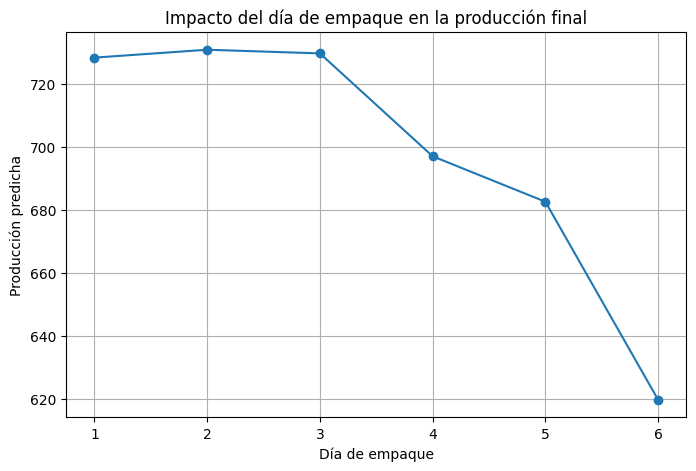

In [46]:
import matplotlib.pyplot as plt

sim = simular_dias(7500, sector=3, mes=6)

plt.figure(figsize=(8,5))

plt.plot(
    sim["Dia_Empaque"],
    sim["Produccion_Predicha"],
    marker="o"
)

plt.title("Impacto del día de empaque en la producción final")
plt.xlabel("Día de empaque")
plt.ylabel("Producción predicha")

plt.grid(True)
plt.show()


In [47]:
sim["Perdida_vs_dia1"] = sim["Produccion_Predicha"].iloc[0] - sim["Produccion_Predicha"]

sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1
0,1,728.43,0.00
1,2,730.94,-2.51
2,3,729.77,-1.34
3,4,697.09,31.34
4,5,682.65,45.78
5,6,619.76,108.67


In [48]:
sim["Perdida_%"] = (
    sim["Perdida_vs_dia1"] /
    sim["Produccion_Predicha"].iloc[0]
) * 100

sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%
0,1,728.43,0.00,0.000000
1,2,730.94,-2.51,-0.344577
2,3,729.77,-1.34,-0.183957
3,4,697.09,31.34,4.302404
4,5,682.65,45.78,6.284749
5,6,619.76,108.67,14.918386


In [49]:
sim["Marginal_perdida"] = sim["Produccion_Predicha"].diff() * -1
sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida
0,1,728.43,0.00,0.000000,NaN
1,2,730.94,-2.51,-0.344577,-2.51
2,3,729.77,-1.34,-0.183957,1.17
3,4,697.09,31.34,4.302404,32.68
4,5,682.65,45.78,6.284749,14.44
5,6,619.76,108.67,14.918386,62.89


In [50]:
sim["Elasticidad"] = (
    sim["Produccion_Predicha"].pct_change() /
    sim["Dia_Empaque"].pct_change()
)

sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad
0,1,728.43,0.00,0.000000,NaN,NaN
1,2,730.94,-2.51,-0.344577,-2.51,0.003446
2,3,729.77,-1.34,-0.183957,1.17,-0.003201
3,4,697.09,31.34,4.302404,32.68,-0.134344
4,5,682.65,45.78,6.284749,14.44,-0.082859
5,6,619.76,108.67,14.918386,62.89,-0.460631


In [51]:
sim["Cambio_elasticidad"] = sim["Elasticidad"].diff().abs()

sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad,Cambio_elasticidad
0,1,728.43,0.00,0.000000,NaN,NaN,NaN
1,2,730.94,-2.51,-0.344577,-2.51,0.003446,NaN
2,3,729.77,-1.34,-0.183957,1.17,-0.003201,0.006647
3,4,697.09,31.34,4.302404,32.68,-0.134344,0.131142
4,5,682.65,45.78,6.284749,14.44,-0.082859,0.051485
5,6,619.76,108.67,14.918386,62.89,-0.460631,0.377773


In [52]:
sim.sort_values("Cambio_elasticidad", ascending=False)


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad,Cambio_elasticidad
5,6,619.76,108.67,14.918386,62.89,-0.460631,0.377773
3,4,697.09,31.34,4.302404,32.68,-0.134344,0.131142
4,5,682.65,45.78,6.284749,14.44,-0.082859,0.051485
2,3,729.77,-1.34,-0.183957,1.17,-0.003201,0.006647
0,1,728.43,0.00,0.000000,NaN,NaN,NaN
1,2,730.94,-2.51,-0.344577,-2.51,0.003446,NaN


In [53]:
sim["Eficiencia_marginal"] = sim["Produccion_Predicha"] / sim["Dia_Empaque"]

sim.sort_values("Eficiencia_marginal", ascending=False)


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad,Cambio_elasticidad,Eficiencia_marginal
0,1,728.43,0.00,0.000000,NaN,NaN,NaN,728.430000
1,2,730.94,-2.51,-0.344577,-2.51,0.003446,NaN,365.470000
2,3,729.77,-1.34,-0.183957,1.17,-0.003201,0.006647,243.256667
3,4,697.09,31.34,4.302404,32.68,-0.134344,0.131142,174.272500
4,5,682.65,45.78,6.284749,14.44,-0.082859,0.051485,136.530000
5,6,619.76,108.67,14.918386,62.89,-0.460631,0.377773,103.293333


In [54]:
sim["Caida_eficiencia_%"] = sim["Eficiencia_marginal"].pct_change() * -100
sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad,Cambio_elasticidad,Eficiencia_marginal,Caida_eficiencia_%
0,1,728.43,0.00,0.000000,NaN,NaN,NaN,728.430000,NaN
1,2,730.94,-2.51,-0.344577,-2.51,0.003446,NaN,365.470000,49.827712
2,3,729.77,-1.34,-0.183957,1.17,-0.003201,0.006647,243.256667,33.440045
3,4,697.09,31.34,4.302404,32.68,-0.134344,0.131142,174.272500,28.358592
4,5,682.65,45.78,6.284749,14.44,-0.082859,0.051485,136.530000,21.657175
5,6,619.76,108.67,14.918386,62.89,-0.460631,0.377773,103.293333,24.343856


In [55]:
sim_final = sim.copy()
sim_final


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad,Cambio_elasticidad,Eficiencia_marginal,Caida_eficiencia_%
0,1,728.43,0.00,0.000000,NaN,NaN,NaN,728.430000,NaN
1,2,730.94,-2.51,-0.344577,-2.51,0.003446,NaN,365.470000,49.827712
2,3,729.77,-1.34,-0.183957,1.17,-0.003201,0.006647,243.256667,33.440045
3,4,697.09,31.34,4.302404,32.68,-0.134344,0.131142,174.272500,28.358592
4,5,682.65,45.78,6.284749,14.44,-0.082859,0.051485,136.530000,21.657175
5,6,619.76,108.67,14.918386,62.89,-0.460631,0.377773,103.293333,24.343856


In [56]:
import pandas as pd

def predecir_produccion(modelo, prod_corte, dia_final, sector, mes):
    datos = pd.DataFrame({
        "PROD_CORTE": [prod_corte],
        "DIA_FINAL": [dia_final],
        "SECTOR": [sector],
        "MES": [mes]
    })
    return float(modelo.predict(datos)[0])

def simular_dias(modelo, prod_corte, sector, mes):
    resultados = []
    for dia in range(1, 7):
        pred = predecir_produccion(modelo, prod_corte, dia, sector, mes)
        resultados.append((dia, round(pred, 2)))

    sim = pd.DataFrame(resultados, columns=["Dia_Empaque", "Produccion_Predicha"])
    sim["Perdida_vs_dia1"] = sim["Produccion_Predicha"].iloc[0] - sim["Produccion_Predicha"]
    sim["Perdida_%"] = (sim["Perdida_vs_dia1"] / sim["Produccion_Predicha"].iloc[0]) * 100
    sim["Marginal_perdida"] = sim["Produccion_Predicha"].diff() * -1
    sim["Elasticidad"] = sim["Produccion_Predicha"].pct_change() / sim["Dia_Empaque"].pct_change()
    sim["Cambio_elasticidad"] = sim["Elasticidad"].diff().abs()
    sim["Eficiencia_marginal"] = sim["Produccion_Predicha"] / sim["Dia_Empaque"]
    sim["Caida_eficiencia_%"] = sim["Eficiencia_marginal"].pct_change() * -100

    return sim


# PUBLICACIÓN

In [57]:
import joblib

joblib.dump(modelo, "../app/modelo_ecoheno.pkl")

columnas_modelo = list(X.columns)
joblib.dump(columnas_modelo, "../app/columnas_modelo.pkl")

['../app/columnas_modelo.pkl']

In [58]:
import streamlit as st
import pandas as pd
import joblib

st.set_page_config(page_title="EcoHeno - Simulador", layout="centered")

st.title("EcoHeno: Predicción y simulación de producción final")

@st.cache_resource
def cargar_modelo():
    modelo = joblib.load("../app/modelo_ecoheno.pkl")
    columnas = joblib.load("../app/columnas_modelo.pkl")
    return modelo, columnas

def predecir_produccion(modelo, columnas, prod_corte, dia_final, sector, mes):
    df = pd.DataFrame([{
        "PROD_CORTE": prod_corte,
        "DIA_FINAL": dia_final,
        "SECTOR": sector,
        "MES": mes
    }])

    df = df.reindex(columns=columnas)
    pred = modelo.predict(df)[0]
    return float(pred)

def simular_dias(modelo, columnas, prod_corte, sector, mes):
    resultados = []
    for dia in range(1, 7):
        pred = predecir_produccion(modelo, columnas, prod_corte, dia, sector, mes)
        resultados.append((dia, round(pred, 2)))

    sim = pd.DataFrame(resultados, columns=["Dia_Empaque", "Produccion_Predicha"])

    sim["Perdida_vs_dia1"] = sim["Produccion_Predicha"].iloc[0] - sim["Produccion_Predicha"]
    sim["Perdida_%"] = (sim["Perdida_vs_dia1"] / sim["Produccion_Predicha"].iloc[0]) * 100
    sim["Marginal_perdida"] = sim["Produccion_Predicha"].diff() * -1
    sim["Elasticidad"] = sim["Produccion_Predicha"].pct_change() / sim["Dia_Empaque"].pct_change()
    sim["Cambio_elasticidad"] = sim["Elasticidad"].diff().abs()
    sim["Eficiencia_marginal"] = sim["Produccion_Predicha"] / sim["Dia_Empaque"]
    sim["Caida_eficiencia_%"] = sim["Eficiencia_marginal"].pct_change() * -100

    return sim

modelo, columnas = cargar_modelo()

st.sidebar.header("Entradas")

prod_corte = st.sidebar.number_input("Producción en corte (PROD_CORTE)", min_value=0.0, value=7500.0, step=10.0)
sector = st.sidebar.selectbox("Sector", options=list(range(1, 9)), index=2)
mes = st.sidebar.selectbox("Mes", options=list(range(1, 13)), index=5)
dia_final = st.sidebar.selectbox("Día de empaque", options=list(range(1, 7)), index=4)

st.subheader("Predicción puntual")

pred = predecir_produccion(modelo, columnas, prod_corte, dia_final, sector, mes)
st.write(f"Producción final predicha: {pred:.2f}")

st.subheader("Simulación por días 1 a 6")

sim = simular_dias(modelo, columnas, prod_corte, sector, mes)

st.dataframe(sim, use_container_width=True)

st.subheader("Gráfico")

st.line_chart(sim.set_index("Dia_Empaque")["Produccion_Predicha"])

st.subheader("Regla operativa sugerida")

umbral = sim.loc[sim["Cambio_elasticidad"].idxmax(), "Dia_Empaque"]
st.write(f"Mayor cambio de elasticidad detectado en el día: {int(umbral)}")
st.write("Recomendación: evitar operar después del día 5 si el umbral cae en 6.")

2026-02-01 15:32:30.626 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 15:32:30.627 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 15:32:30.880 
  command:

    streamlit run c:\Users\USUARIO\Desktop\ECO_HENO\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2026-02-01 15:32:30.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 15:32:30.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 15:32:30.883 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 15:32:30.946 Thread 'MainThread': missing ScriptRunContext! This warning can be ig